# 线性回归
## 线性回归算法步骤
1. 读取数据
2. 定义模型：Linear
3. 初始化模型参数：[w、b]
4. 定义损失函数：MSELOSS
5. 定义优化函数：SGD
6. 训练：loss.backward、optimizer.step
7. 检查结果

## 问题：模型参数要随机初始化

具体来说，在连接到相同输入的隐藏层中并排的节点必须有不同的权重，这样才能使学习算法更新权重。

这通常被称为在训练期间需要打破对称性（symmetry）。

也许唯一已知的完全确定的性质是初始参数需要不同单元之间“打破对称性”。如果具有相同激活功能的两个隐藏单元连接到相同的输入，则这些单元必须具有不同的初始参数。如果它们具有相同的初始参数，那么应用于确定性损失和型的确定性学习算法将以相同的方式不断更新这两个单元。

[为什么要随机权重初始化?](http://www.atyun.com/26002.html)

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
[k for k in plt.rcParams if "fig" in k and "size" in k] 

['figure.figsize', 'figure.titlesize']

In [3]:
display.set_matplotlib_formats("svg")
plt.rcParams["figure.figsize"] = (4,8)

## 生成数据集

In [4]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = np.random.randn(num_examples, num_inputs)
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b

labels += np.random.normal(scale=0.01, size=labels.size)

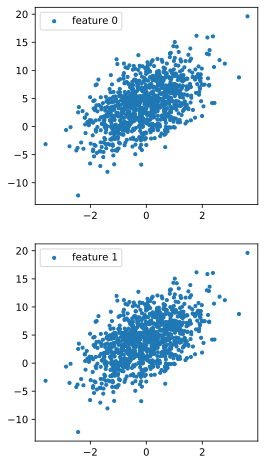

In [5]:
fig, axes = plt.subplots(2,1)
axes[0].scatter(features[:,0], labels, 10, label="feature 0")
axes[0].legend()
axes[1].scatter(features[:,0], labels, 10, label="feature 1")
axes[1].legend()

## 线性回归从零开始实现

In [6]:
batch_size = 10
lr = 0.03
num_epochs = 5

### pytorch版

In [7]:
import torch
torch.__version__

'1.0.0'

#### 读取数据集

In [8]:
def data_iter_torch(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        sample_indexes = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,sample_indexes), labels.index_select(0,sample_indexes)

In [9]:
features_torch = torch.tensor(features, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)
features_torch.shape, labels_torch.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [10]:
for X,y in data_iter_torch(batch_size, features_torch, labels_torch):
    print(X,'\n', y)
    break

tensor([[ 0.8391, -1.9096],
        [-0.6793, -0.4927],
        [ 0.9027,  0.8272],
        [-0.3910, -1.4534],
        [ 1.3885,  1.0857],
        [ 0.2299, -1.2898],
        [ 0.8047, -0.8945],
        [-0.7443, -2.3010],
        [ 0.3139, -0.1560],
        [-0.3046, -1.0246]]) 
 tensor([12.3516,  4.5111,  3.2023,  8.3489,  3.2858,  9.0361,  8.8499, 10.5386,
         5.3568,  7.0826])


#### 定义模型

In [11]:
def linreg_torch(X, w, b):
    return torch.mm(X,w)+b

#### 初始化模型参数

In [12]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)), dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)
w.shape, b.shape

(torch.Size([2, 1]), torch.Size([1]))

In [13]:
linreg_torch(features_torch, w, b).sum().item()

-0.2694450914859772

In [14]:
linreg_torch(features_torch, w, b).shape

torch.Size([1000, 1])

#### 定义损失函数MSE

In [15]:
def squared_loss_torch(y_hat, y):
    return (y_hat-y.view(y_hat.shape)) ** 2/2

In [16]:
squared_loss_torch(linreg_torch(features_torch,w,b), labels_torch).shape

torch.Size([1000, 1])

#### 定义优化函数

In [17]:
def sgd_torch(params, lr, batch_size):
    for param in params:
        param.data -= lr*param.grad / batch_size

#### 训练
**mxnet不需要重置梯度。**

In [18]:
for epoch in range(num_epochs):
    for X,y in data_iter_torch(batch_size, features_torch, labels_torch):
        l = squared_loss_torch(linreg_torch(X,w,b),y).sum()
        l.backward()
        sgd_torch([w,b],lr,batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = squared_loss_torch(linreg_torch(features_torch,w,b), labels_torch).mean().item()
    print("epoch {:d}, loss {:.6f}".format(epoch+1, train_l))

epoch 1, loss 0.041755
epoch 2, loss 0.000165
epoch 3, loss 0.000049
epoch 4, loss 0.000049
epoch 5, loss 0.000049


#### 检查结果

In [19]:
print(true_w,"\n", w.data.numpy().tolist())

[2, -3.4] 
 [[1.9995906352996826], [-3.399710178375244]]


In [20]:
print(true_b,"\n", b.data.numpy().tolist())

4.2 
 [4.199484348297119]


### mxnet版

In [21]:
from mxnet import autograd, nd
import mxnet
print(mxnet.__version__)

1.5.0


#### 读取数据

In [22]:
features_mxnet = nd.array(features)
labels_mxnet = nd.array(labels)

In [23]:
features_mxnet.shape, labels_mxnet.shape

((1000, 2), (1000,))

In [24]:
def data_iter_mxnet(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        sample_indexes = nd.array(indices[i:min(i+batch_size, num_examples)])
        yield features.take(sample_indexes), labels.take(sample_indexes)

In [25]:
features_mxnet = nd.array(features)
labels_mxnet = nd.array(labels)
features_mxnet.shape, features_mxnet.shape

((1000, 2), (1000, 2))

In [26]:
for X,y in data_iter_mxnet(batch_size, features_mxnet, labels_mxnet):
    print(X,'\n', y)
    break


[[ 1.3271769  -0.67818326]
 [-0.40806422  0.04750201]
 [ 0.64261615  0.45933148]
 [-0.02106808  1.5278339 ]
 [-0.1569641   1.0837741 ]
 [-1.3027542   1.4203621 ]
 [ 1.0807507   0.99554956]
 [-0.15324838  0.7236057 ]
 [-1.0211872  -0.5836538 ]
 [ 0.2065218  -0.16414557]]
<NDArray 10x2 @cpu(0)> 
 
[ 9.159718    3.2179074   3.9081223  -1.0466733   0.21228571 -3.2357345
  2.976833    1.4332534   4.1279306   5.1607575 ]
<NDArray 10 @cpu(0)>


#### 定义模型

In [27]:
def linreg_mxnet(X, w, b):
    return nd.dot(X,w)+b

#### 初始化模型参数

In [28]:
w = nd.random.normal(loc=0.0, scale=0.01, shape=(num_inputs,1))
b = nd.zeros(shape=(1,))
w.attach_grad()
b.attach_grad()
w.shape, b.shape

((2, 1), (1,))

In [29]:
linreg_mxnet(features_mxnet, w, b).sum().asscalar()

-0.18834433

In [30]:
linreg_mxnet(features_mxnet, w, b).shape

(1000, 1)

#### 定义损失函数

In [31]:
def squared_loss_mxnet(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape)) ** 2/2

In [32]:
squared_loss_mxnet(linreg_mxnet(features_mxnet,w,b), labels_mxnet).shape

(1000, 1)

In [33]:
squared_loss_mxnet(linreg_mxnet(features_mxnet,w,b), labels_mxnet).mean().asscalar()

16.137047

#### 定义优化函数
**mxnet的数据操作会开辟新空间。**

In [34]:
def sgd_mxnet(params, lr, batch_size):
    for param in params:
        param[:] = param - lr*param.grad / batch_size

#### 训练

In [35]:
for epoch in range(num_epochs):
    for X,y in data_iter_mxnet(batch_size, features_mxnet, labels_mxnet):
        with autograd.record():
            l = squared_loss_mxnet(linreg_mxnet(X,w,b),y)
        l.backward()
        sgd_mxnet([w,b],lr,batch_size)
    train_l = squared_loss_mxnet(linreg_mxnet(features_mxnet,w,b), labels_mxnet).mean().asscalar()
    print("epoch {:d}, loss {:.6f}".format(epoch+1, train_l))

epoch 1, loss 0.042212
epoch 2, loss 0.000166
epoch 3, loss 0.000049
epoch 4, loss 0.000049
epoch 5, loss 0.000049


#### 检查结果

In [36]:
print(true_w,"\n", w.asnumpy().tolist())

[2, -3.4] 
 [[2.0000104904174805], [-3.399519443511963]]


In [37]:
print(true_b,"\n", b.asnumpy().tolist())

4.2 
 [4.199704170227051]


## 框架简洁实现

### pytorch版

In [38]:
import torch.utils.data as data_torch
from torch import nn, optim
from torch.nn import init
torch.manual_seed(1)
torch.set_default_tensor_type("torch.FloatTensor")

#### 读取数据

In [39]:
dataset_torch = data_torch.TensorDataset(features_torch, labels_torch)
dataiter_torch = data_torch.DataLoader(dataset=dataset_torch, 
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=4)

#### 定义模型

##### 方法1

In [40]:
class LinearNet(nn.Module):
    def __init__(self, n_feaure):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feaure, 1)
    
    def forward(self, x):
        return self.linear(x)    

In [41]:
net1 = LinearNet(num_inputs)
print(net1)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [42]:
net1(features_torch).shape

torch.Size([1000, 1])

##### 方法2

In [43]:
net2 = nn.Sequential(nn.Linear(num_inputs, 1))
print(net2)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


In [44]:
net2(features_torch).shape

torch.Size([1000, 1])

##### 方法3

In [45]:
net3 = nn.Sequential()
net3.add_module("li", nn.Linear(num_inputs,1))
print(net3)

Sequential(
  (li): Linear(in_features=2, out_features=1, bias=True)
)


##### 方法4

In [46]:
from collections import OrderedDict
net4 = nn.Sequential(OrderedDict([("lin", nn.Linear(num_inputs,1))]))
print(net4)

Sequential(
  (lin): Linear(in_features=2, out_features=1, bias=True)
)


#### 初始化模型参数

In [47]:
init.normal_(net1.linear.weight, mean=0.0, std=0.01)
init.constant_(net1.linear.bias, val=0.0)
print(net1.linear.weight,"\n",net1.linear.bias)

Parameter containing:
tensor([[-0.0152,  0.0038]], requires_grad=True) 
 Parameter containing:
tensor([0.], requires_grad=True)


In [48]:
init.normal_(net2[0].weight, mean=0.0, std=0.01)
init.constant_(net2[0].bias, val=0.0)
print(net2[0].weight,"\n",net2[0].bias)

Parameter containing:
tensor([[-0.0103, -0.0056]], requires_grad=True) 
 Parameter containing:
tensor([0.], requires_grad=True)


#### 定义损失函数

In [49]:
loss_torch = nn.MSELoss()

In [50]:
loss_torch(net1(features_torch), labels_torch)

tensor(32.2836, grad_fn=<MseLossBackward>)

#### 定义优化函数

In [51]:
optimizer1 = optim.SGD(net1.parameters(), lr=lr)
print(optimizer1)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [52]:
optimizer2 = optim.SGD(net2.parameters(), lr=lr)
print(optimizer2)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


#### 训练

```python
l = loss_torch(output,y.view(-1,1)).sum()
```

**loss函数的两个参数一定要设置成同样大小，否责程序虽能运行，但是结果不正确。**

In [53]:
for epoch in range(num_epochs):
    for X,y in dataiter_torch:
        output = net1(X)
        l = loss_torch(output,y.view(-1,1)).sum()
        optimizer1.zero_grad()
        l.backward()
        optimizer1.step()
    print("epoch {:d}, loss {:.6f}".format(epoch+1, l.item()))

epoch 1, loss 0.000369
epoch 2, loss 0.000077
epoch 3, loss 0.000057
epoch 4, loss 0.000116
epoch 5, loss 0.000104


In [54]:
for epoch in range(num_epochs):
    for X,y in dataiter_torch:
        output = net2(X)
        l = loss_torch(output,y.view(-1,1)).sum()
        optimizer2.zero_grad()
        l.backward()
        optimizer2.step()
    print("epoch {:d}, loss {:.6f}".format(epoch+1, l.item()))

epoch 1, loss 0.000157
epoch 2, loss 0.000121
epoch 3, loss 0.000087
epoch 4, loss 0.000090
epoch 5, loss 0.000032


#### 检查结果

In [55]:
dense = net1.linear
print(true_w," ",dense.weight.data)
print(true_b," ",dense.bias.data)

[2, -3.4]   tensor([[ 1.9992, -3.4003]])
4.2   tensor([4.1997])


In [56]:
dense = net2[0]
print(true_w," ",dense.weight.data)
print(true_b," ",dense.bias.data)

[2, -3.4]   tensor([[ 1.9996, -3.3997]])
4.2   tensor([4.1991])


### mxnet版

In [57]:
from mxnet.gluon import data as data_mxnet
from mxnet.gluon import nn, loss
from mxnet import init, gluon

#### 读取数据

In [58]:
dataset_mxnet = data_mxnet.ArrayDataset(features_mxnet, labels_mxnet)
dataiter_mxnet = data_mxnet.DataLoader(dataset=dataset_mxnet, 
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=4)

#### 定义模型
**mxnet不需要定义输入特征数。**

In [59]:
net5 = nn.Sequential()
net5.add(nn.Dense(1))
print(net5)

Sequential(
  (0): Dense(None -> 1, linear)
)


#### 初始化模型参数 

In [60]:
net5.initialize(init.Normal(sigma=0.01))

#### 定义损失函数

In [61]:
loss_mxnet = loss.L2Loss()

In [62]:
loss_mxnet(net5(features_mxnet), labels_mxnet).shape

(1000,)

#### 定义优化函数

In [63]:
optimizer5 = gluon.Trainer(net5.collect_params(),
                           "sgd", 
                           {"learning_rate":lr})
print(optimizer5)

#### 训练

In [64]:
for epoch in range(num_epochs):
    for X,y in dataiter_mxnet:
        with autograd.record():
            l = loss_mxnet(net5(X),y)
        l.backward()
        optimizer5.step(batch_size)
    l = loss_mxnet(net5(features_mxnet),labels_mxnet)
    print("epoch {:d}, loss {:.6f}".format(epoch+1, l.mean().asscalar()))

epoch 1, loss 0.041617
epoch 2, loss 0.000155
epoch 3, loss 0.000050
epoch 4, loss 0.000049
epoch 5, loss 0.000049


#### 检查结果

In [65]:
dense = net5[0]
print(true_w," ",dense.weight.data())
print(true_b," ",dense.bias.data())

[2, -3.4]   
[[ 1.9997987 -3.3996272]]
<NDArray 1x2 @cpu(0)>
4.2   
[4.199741]
<NDArray 1 @cpu(0)>
